# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import Common_Functions as f

from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_absolute_percentage_error as mape

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
path = os.getcwd()+'/'

# Data Cleaning

1. Drop all rows with missing mcare_counts
2. Drop year column
3. Replace inf values with 0
4. Apply thresholding on the data

In [4]:
data = pd.read_csv(path+'Feature Matrix/processed_data.csv')
data.dropna(subset = ['mcare_count'], inplace = True)
data.drop(columns = ['year'], inplace = True)
data.replace([np.inf, -np.inf], 0, inplace=True)

In [5]:
model_data, future_data = f.data_split(data, count_thresh = 34)

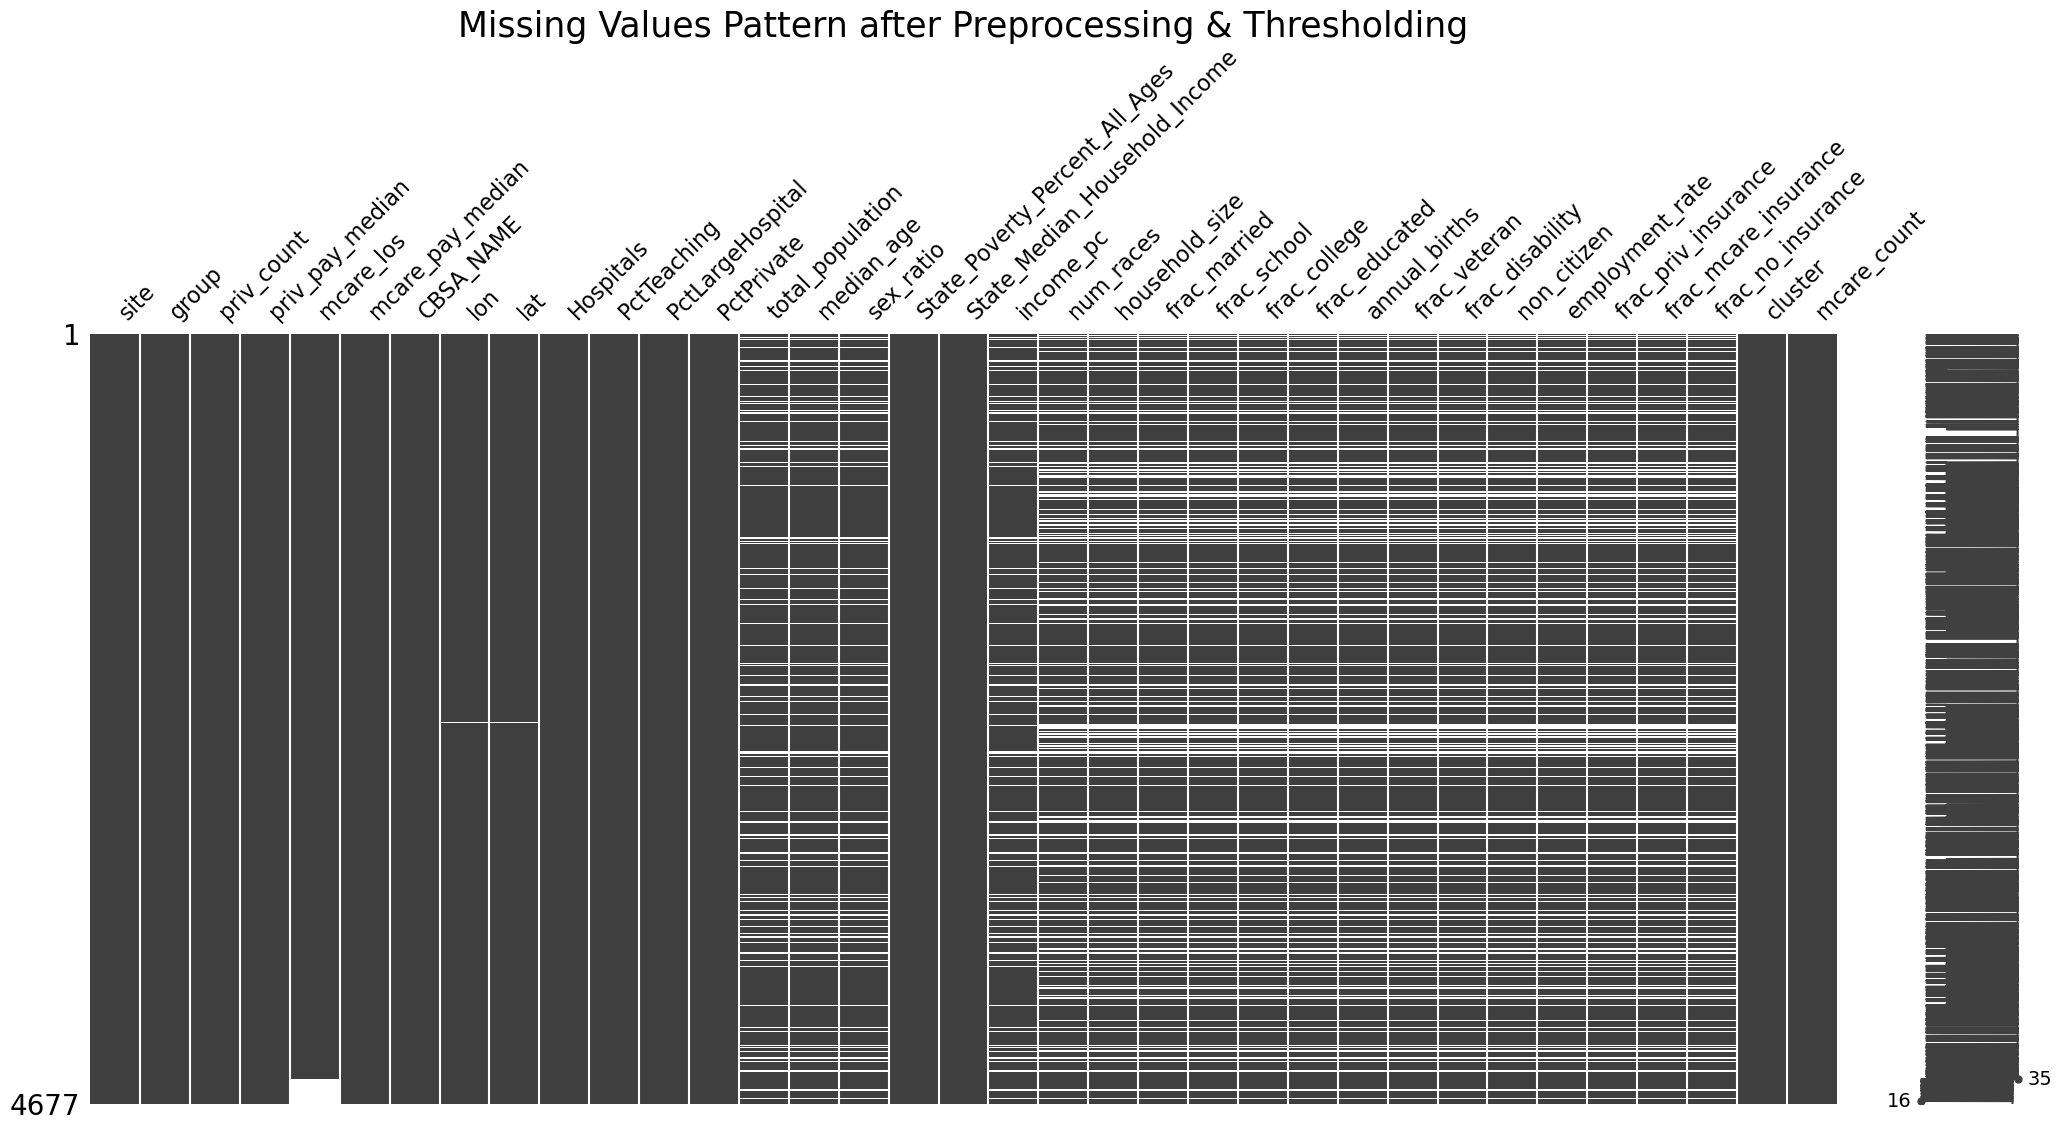

In [6]:
msno.matrix(model_data)
plt.title('Missing Values Pattern after Preprocessing & Thresholding', fontsize = 25)
plt.show()

# Spliting into Cluster Data

In [7]:
clusters = model_data.cluster.unique()
print(clusters)

[0 2 1]


In [8]:
data_0 = model_data[model_data.cluster == 0]
data_1 = model_data[model_data.cluster == 1]
data_2 = model_data[model_data.cluster == 2]

In [9]:
X0 = data_0.drop(columns = 'priv_pay_median')
y0 = data_0['priv_pay_median']

In [10]:
X1 = data_1.drop(columns = 'priv_pay_median')
y1 = data_1['priv_pay_median']

In [11]:
X2 = data_2.drop(columns = 'priv_pay_median')
y2 = data_2['priv_pay_median']

In [12]:
# set by inspecting graph made by Sarthak
optimal_k = {0:14,1:3,2:2}

## Train-Test Split

In [13]:
dev_X0, test_X0, dev_y0, test_y0 = train_test_split(X0, y0, test_size = 0.2, random_state = 42)

In [14]:
dev_X1, test_X1, dev_y1, test_y1 = train_test_split(X1, y1, test_size = 0.2, random_state = 42)

In [15]:
dev_X2, test_X2, dev_y2, test_y2 = train_test_split(X2, y2, test_size = 0.2, random_state = 42)

In [16]:
dev_X = [dev_X0, dev_X1, dev_X2]
dev_y = [dev_y0, dev_y1, dev_y2]
test_X = [test_X0, test_X1, test_X2]
test_y = [test_y0, test_y1, test_y2]

In [56]:
MAPE_dict = {'ankle_fix': 25.57,
             'ant_cerv_fusion': 21.31,
             'bariatric': 11.77,
             'breast reconstruction': 15.60,
             'bsp': 12.16,
             'bunionectomy': 27.99,
             'cardiac ablation': 16.84,
'cardiac_ablaton_ice': 22.32,
'colorect': 10.02,
'fess': 24.07,
'hepat': 34.23,
'hernia': 11.73,
'hysterect': 11.96,
'lap appendectomy': 13.51,
'mastectomy': 23.19,
'post_tls_fusion': 8.96,
'prox_tibia_fixation': 16.18,
'radius/ulna internal fixation': 13.12,
'robotic_assisted_surgery': 18.05,
'rtc_slap_bank': 15.93,
'septoplasty': 14.29,
'tha': 6.81,
'tka': 8.83,
'tpa': 7.07
}
MAPE_df = pd.DataFrame.from_dict(MAPE_dict, orient = 'index', columns=['percent_mape'])
display(MAPE_df)

,percent_mape
ankle_fix,25.57
ant_cerv_fusion,21.31
bariatric,11.77
breast reconstruction,15.60
bsp,12.16
bunionectomy,27.99
cardiac ablation,16.84
cardiac_ablaton_ice,22.32
colorect,10.02
fess,24.07


In [62]:
for clu in test_X:
    merged_df = pd.DataFrame(clu.groupby(['group'])['group'].count()).join(MAPE_df).dropna(subset=["percent_mape"])
    merged_df["mape_contr"] = merged_df['group'] * merged_df["percent_mape"]
    display(merged_df)
    print(merged_df.sum())
    print(merged_df.sum()['mape_contr'])
    print(merged_df.sum()['group'])
    print(merged_df.sum()['mape_contr'] / merged_df.sum()['group'])
    
    

,group,percent_mape,mape_contr
group,,,
bariatric,41,11.77,482.57
breast reconstruction,44,15.60,686.40
bsp,2,12.16,24.32
bunionectomy,35,27.99,979.65
fess,79,24.07,1901.53
hysterect,105,11.96,1255.80
lap appendectomy,41,13.51,553.91
mastectomy,51,23.19,1182.69
radius/ulna internal fixation,21,13.12,275.52


group            546.00
percent_mape     201.64
mape_contr      9330.94
dtype: float64
9330.940000000002
546.0
17.089633699633705


,group,percent_mape,mape_contr
group,,,
hepat,10,34.23,342.30
post_tls_fusion,28,8.96,250.88


group            38.00
percent_mape     43.19
mape_contr      593.18
dtype: float64
593.18
38.0
15.61


,group,percent_mape,mape_contr
group,,,
ankle_fix,36,25.57,920.52
ant_cerv_fusion,29,21.31,617.99
cardiac ablation,26,16.84,437.84
cardiac_ablaton_ice,17,22.32,379.44
colorect,38,10.02,380.76
hernia,33,11.73,387.09
prox_tibia_fixation,1,16.18,16.18
tha,56,6.81,381.36
tka,79,8.83,697.57


group            317.00
percent_mape     146.68
mape_contr      4232.89
dtype: float64
4232.89
317.0
13.352965299684543
